<a href="https://colab.research.google.com/github/berkezkul/Letterbox_Scraping_Analysis/blob/main/Movie_Analysis_TMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor   #çok değişkenli aykırı değer yakalama
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scipy.stats as stats

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [ ]:
def load():
    data = pd.read_csv("/content/sample_data/TMDBmovies_details.csv")
    return data

In [ ]:
df = load()
df.head(10)

,title,release_date,rating,director,writer,genres,runtime,original_language,budget,revenue
0,Garfield,31/05/2024 (TR),64,Mark Dindal,NaN,"Animasyon,Komedi,Aile",1h 41m,İngilizce,-,"$22,000,000.00"
1,Hayalet Avcıları: Ürperti,29/03/2024 (TR),66,Gil Kenan,Gil Kenan,"Fantastik,Macera,Komedi",1h 55m,İngilizce,"$100,000,000.00","$195,102,874.00"
2,Arınma,26/04/2024 (TR),62,Michael Mohan,NaN,"Korku,Gizem,Gerilim",1h 29m,İngilizce,"$9,000,000.00","$22,314,913.00"
3,NaN,19/04/2024 (TR),61,Zack Snyder,NaN,"Bilim-Kurgu,Aksiyon,Dram",2h 3m,İngilizce,"$83,000,000.00",-
4,Çıkış Yok,26/01/2024 (TR),64,Claudio Fäh,Andy Mayson,"Aksiyon,Korku,Gerilim",1h 35m,İngilizce,-,-
5,Ape vs. Mecha Ape,24/03/2023 (US),53,Marc Gottlieb,Marc Gottlieb,"Aksiyon,Bilim-Kurgu",1h 20m,İngilizce,-,-
6,Kung Fu Panda 4,05/04/2024 (TR),71,Mike Mitchell,Jonathan Aibel,"Animasyon,Aksiyon,Aile,Komedi,Fantastik",1h 34m,İngilizce,"$85,000,000.00","$520,540,090.00"
7,Dune: Çöl Gezegeni Bölüm İki,01/03/2024 (TR),82,Denis Villeneuve,NaN,"Bilim-Kurgu,Macera",2h 45m,İngilizce,"$190,000,000.00","$704,300,257.00"
8,Maymunlar Cehennemi: Yeni Krallık,10/05/2024 (TR),69,Wes Ball,Josh Friedman,"Bilim-Kurgu,Macera,Aksiyon",2h 25m,İngilizce,-,-
9,NaN,05/04/2024 (TR),65,Adam Wingard,NaN,"Aksiyon,Bilim-Kurgu,Macera",1h 55m,İngilizce,"$150,000,000.00","$546,503,756.00"


In [ ]:
def get_column_info(df, columns_of_interest):
    """
     Her değişken içindeki kaç sınıf olduğunu ve sınıfların kaçar tane veri barındırdığını görmek için kullanacağız.

    """
    column_info = {}
    for col in columns_of_interest:
        nunique = df[col].nunique()
        value_counts = df[col].value_counts()
        column_info[col] = {
            "unique_value_count": nunique,
            "value_counts": value_counts.to_dict()
        }
    return column_info

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [ ]:
missing_values_table(df, True)

          n_miss  ratio
writer      3303 60.000
title       1103 20.040
director       4  0.070
genres         2  0.040


['title', 'director', 'writer', 'genres']

In [ ]:
def preprocess_data(df):

  '''DATA CLEANING'''

  #budget ve revenue da $ ve virgülleri kaldırdık.
  df['revenue'] = df['revenue'].str.replace('$', '').str.replace(',', '')
  df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

  df['budget'] = df['budget'].str.replace('$', '').str.replace(',', '')
  df['budget'] = pd.to_numeric(df['budget'], errors='coerce')



  '''TRANSFORMATION'''

  #frekansı çok düşük olan sınıfları toparlayıp other dedik.
  df['original_language'] = df['original_language'].apply(lambda x: x if x in
   ['İngilizce', 'Japonca', 'Fransızca', 'Korece', 'İtalyanca', 'Çince', 'İspanyolca','Almanca','Rusça'] else 'Other')

  #one hot encoding ile language i düzenledik.
  language_dummies = pd.get_dummies(df['original_language'], prefix='language')
  df = pd.concat([df, language_dummies], axis=1)
  # True/False değerlerini 0/1 olarak dönüştürme
  df[language_dummies.columns] = df[language_dummies.columns].astype(int)

  #one hot encoding ile genresi düzenledik.
  genres_dummies = df['genres'].str.get_dummies(sep=',')
  genres_dummies = genres_dummies.add_prefix('genres_')
  #df.drop(columns=['genres'], inplace=True)
  df = pd.concat([df, genres_dummies], axis=1)


  #1h 41m yerine direkt 101 olarak dakikayı yazıyoruz.
  def convert_runtime(runtime):
        if pd.isnull(runtime):
            return 0
        h, m = 0, 0
        if 'h' in runtime:
            h = int(runtime.split('h')[0].strip())
        if 'm' in runtime:
            m = int(runtime.split('h')[1].split('m')[0].strip()) if 'h' in runtime else int(runtime.split('m')[0].strip())
        return h * 60 + m

  df['runtime'] = df['runtime'].apply(convert_runtime)



  '''FEATURE EXTRACTION'''

  #release_date sütunundan yılı alarak yeni bir değişken oluşturduk.
  df['release_year'] = df['release_date'].apply(lambda x: int(x.split('/')[2].split()[0]) if pd.notnull(x) else 0)

  #release_date sütunundan aylara göre filmin çıktığı sezonu belirten bir değişken oluşturduk.
  def get_season(month):
      if month in [12, 1, 2]:
          return 'Winter'
      elif month in [3, 4, 5]:
          return 'Spring'
      elif month in [6, 7, 8]:
          return 'Summer'
      else:
          return 'Autumn'

  df['release_month'] = df['release_date'].apply(lambda x: int(x.split('/')[1]) if pd.notnull(x) else 0)
  df['release_season'] = df['release_month'].apply(get_season)
  df.drop(columns=['release_month'], inplace=True)

  #release_seasona one hot encoding ekledik.
  season_dummies = pd.get_dummies(df['release_season'], prefix='season')
  df = pd.concat([df, season_dummies], axis=1)


  #revenue-budget = net_gain
  df['net_gain'] = df.apply(lambda row: row['revenue'] - row['budget'] if pd.notnull(row['revenue']) and pd.notnull(row['budget']) else 0, axis=1)

  df_directors = df[df['director'] != 'Unknown']
  director_counts = df_directors['director'].value_counts().reset_index()

  director_counts.columns = ['director', 'film_count']
  director_ratings = df_directors.groupby('director')['rating'].mean().reset_index()
  director_ratings.columns = ['director', 'avg_rating']

  df = df.merge(director_counts, on='director', how='left')
  df = df.merge(director_ratings, on='director', how='left')
  df['film_count'] = df['film_count'].fillna(0).astype(int)

  #one hot encoding yapılanlar drop edildi
  df.drop(columns=['release_date', 'release_season', 'genres', 'original_language'], inplace=True)


  '''MISSING VALUES'''

  # Budget ve revenue sütunlarındaki eksik değerleri yönetmenin ortalama değerleriyle doldurma
  df['budget'] = df.groupby('director')['budget'].transform(lambda x: x.fillna(x.mean() if x.count() > 1 else df['budget'].mean()))
  df['revenue'] = df.groupby('director')['revenue'].transform(lambda x: x.fillna(x.mean() if x.count() > 1 else df['revenue'].mean()))

  #yönetmeni olmayan veya title ı olmayan filmleri sildik.
  df = df.dropna(subset=['director'])
  df = df.dropna(subset=['title'])

  '''NORMALIZATION'''
  features = ['release_year', 'runtime', 'budget', 'revenue', 'net_gain', 'film_count', 'avg_rating'] + \
               [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('season_')]

  X = df[features]  # Kalan NaN değerleri 0 ile doldur


  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  return df, X_scaled, scaler

In [ ]:
def cluster_movies(X_scaled):
    # K-means kullanarak filmleri grupladık.
    kmeans = KMeans(n_clusters=5, random_state=42)
    movie_clusters = kmeans.fit_predict(X_scaled)
    return movie_clusters

In [ ]:
def cluster_directors(df):
    director_features = ['film_count', 'budget', 'revenue', 'net_gain'] + \
                        [col for col in df.columns if col.startswith('genres_')]

    # Yönetmen başına düşen ortalama değerleri hesapladık.
    X_directors = df.groupby('director')[director_features].mean().reset_index()

    # Yönetmen başına düşen özellikleri normalize ettik.
    scaler = StandardScaler()
    X_directors_scaled = scaler.fit_transform(X_directors[director_features])

    # K-means kullanarak yönetmenleri grupladık.
    kmeans_directors = KMeans(n_clusters=5, random_state=42)
    X_directors['director_cluster'] = kmeans_directors.fit_predict(X_directors_scaled)

    return X_directors

In [ ]:
'''VISUALIZATION'''

def visualize_clusters(df, movie_clusters):
    # Film kümelerini görselleştirme
    df['movie_cluster'] = movie_clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x=df['budget'], y=df['revenue'], c=df['movie_cluster'], cmap='viridis')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')
    plt.title('Film Kümeleri')
    plt.colorbar(scatter)
    plt.show()
    print("######################################")

def visualize_boxplot(df):
    # Film kümelerine göre rating dağılımı
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='movie_cluster', y='rating', data=df)
    plt.xlabel('Film Kümesi')
    plt.ylabel('Rating')
    plt.title('Film Kümelerine Göre Rating Dağılımı')
    plt.show()
    print("######################################")

    # Genres oranlarını hesapladık.
    genre_cols = [col for col in df.columns if col.startswith('genres_')]
    clusters = df['movie_cluster'].unique()

    genre_ratios = {}
    for cluster in clusters:
        cluster_data = df[df['movie_cluster'] == cluster]
        total_count = cluster_data.shape[0]
        genre_ratios[cluster] = (cluster_data[genre_cols].sum() / total_count * 100).sort_values(ascending=False)

    # Oranları tablo olarak görselleştirdik.
    genre_ratios_df = pd.DataFrame(genre_ratios).fillna(0).T
    genre_ratios_df = genre_ratios_df.round(2)  # Oranları yuvarlama
    display(genre_ratios_df)

    return genre_ratios_df



def visualize_top_directors(df):
    # Sayısal sütunları seçtik.
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    # En yüksek rating ortalamasına sahip 10 yönetmeni görselleştirdik.
    top_directors = df.groupby('director')[numeric_cols].mean().sort_values(by='avg_rating', ascending=False).head(10)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_directors.index, y=top_directors['avg_rating'])
    plt.xlabel('Director')
    plt.ylabel('Average Rating')
    plt.title('Top 10 Directors by Average Rating')
    plt.xticks(rotation=45)
    plt.show()
    print("######################################")


In [ ]:
#Kümelerin hangi genres i ne kadar barındırdığını inceledik.

def visualize_genres_in_clusters(df):
    # Kümeler ve genres lerin toplamlarını hesapladık.
    genre_cols = [col for col in df.columns if col.startswith('genres_')]
    clusters = df['movie_cluster'].unique()

    # Her bir küme için her genres için count ı hesapladık
    genre_distributions = {}
    for cluster in clusters:
        cluster_data = df[df['movie_cluster'] == cluster]
        genre_sums = cluster_data[genre_cols].sum().sort_values(ascending=False)
        genre_distributions[cluster] = genre_sums

    # Visualization
    fig, axes = plt.subplots(nrows=len(clusters), ncols=1, figsize=(12, 8 * len(clusters)))

    if len(clusters) == 1:
        axes = [axes]

    for i, cluster in enumerate(clusters):
        sns.barplot(x=genre_distributions[cluster].index.str.replace('genres_', ''), y=genre_distributions[cluster].values, ax=axes[i])
        axes[i].set_title(f'Cluster {cluster} - Genre Distribution')
        axes[i].set_xlabel('Genre')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(df):
    # Modeli eğitmek için veriyi hazırlama

    features = ['release_year', 'runtime', 'budget', 'revenue', 'net_gain', 'film_count'] + \
               [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('season_')]
    X = df[features]
    y = df['rating']

    # Veriyi eğitim ve test setlerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression modelini eğitme
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Modelin performansını değerlendirme
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Squared Error: {mse}")

    return model, X_test, y_test, y_pred

In [ ]:
def evaluate_model_performance(y_test, y_pred):
    # Gerçek vs Tahmin Edilen Değerlerin Görselleştirilmesi: Kırmızı kesikli çizgi, mükemmel tahmin çizgisi (artıklar = gerçek değerler = tahmin edilen değerler)
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred)
    plt.xlabel('Gerçek Ratingler')
    plt.ylabel('Tahmin Edilen Ratingler')
    plt.title('Gerçek vs Tahmin Edilen Ratingler')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()

    # Artıkların Görselleştirilmesi (Residual Plot)
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 8))
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Tahmin Edilen Ratingler')
    plt.ylabel('Artıklar')
    plt.title('Residual Plot')
    plt.show()

    # Artıkların Histogramı
    plt.figure(figsize=(10, 8))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Artıklar')
    plt.title('Histogram of Residuals')
    plt.show()

    # QQ Plot: Artıkların normal dağılıma ne kadar uyduğunu değerlendirdik.
    plt.figure(figsize=(10, 8))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


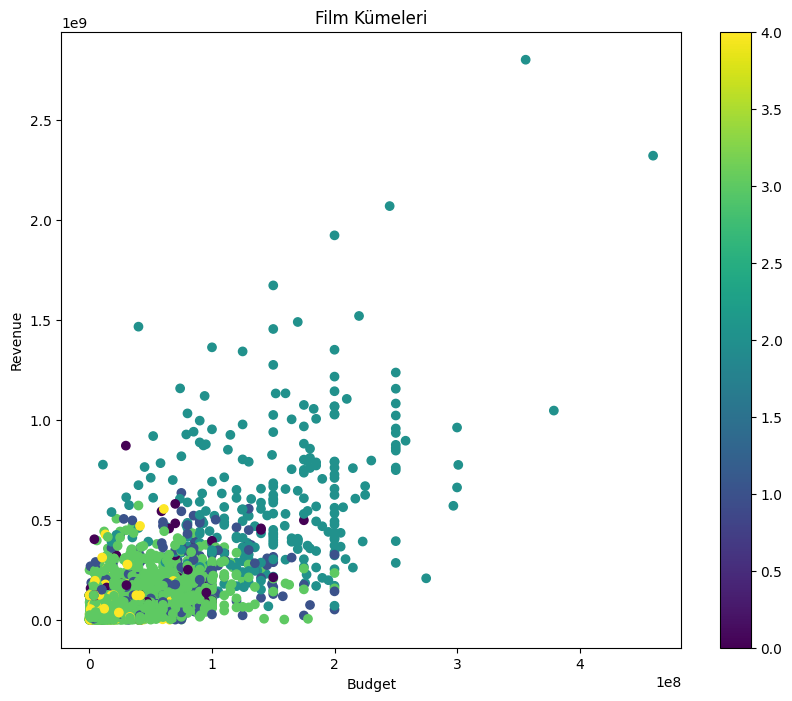

######################################


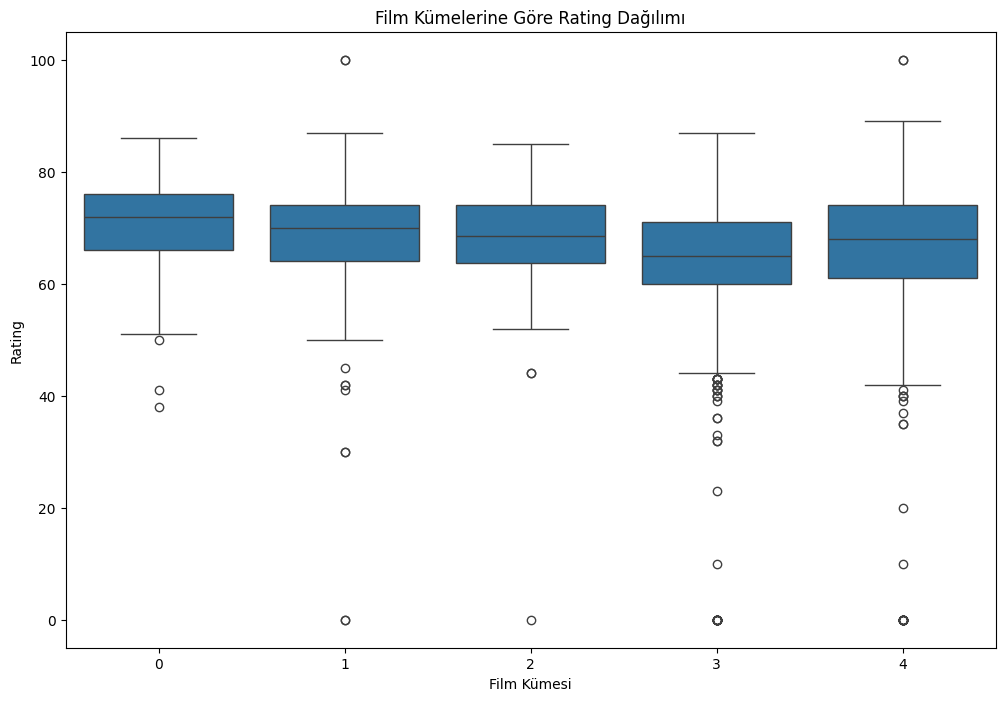

######################################


,genres_Aile,genres_Aksiyon,genres_Animasyon,genres_Belgesel,genres_Bilim-Kurgu,genres_Dram,genres_Fantastik,genres_Gerilim,genres_Gizem,genres_Komedi,genres_Korku,genres_Macera,genres_Müzik,genres_Romantik,genres_Savaş,genres_Suç,genres_TV film,genres_Tarih,genres_Vahşi Batı
1,68.890,28.010,78.180,0.000,18.400,13.360,44.950,0.650,4.400,46.580,2.120,47.880,2.770,8.140,0.000,1.140,4.230,0.330,0.330
3,2.940,25.820,0.220,0.930,11.240,43.340,6.970,34.830,11.020,31.780,19.030,9.910,2.510,17.590,0.000,19.280,0.860,4.270,2.550
2,14.180,72.760,10.070,0.000,45.150,14.550,28.730,16.420,3.360,16.040,2.240,79.480,0.750,2.990,0.000,5.220,0.000,0.370,0.750
4,1.880,28.380,0.850,1.370,8.890,56.580,7.690,28.210,8.550,22.050,15.210,12.820,0.510,21.540,0.000,16.240,0.170,4.790,1.540
0,0.000,44.300,2.010,0.000,3.360,75.840,3.360,16.110,0.670,8.720,2.680,16.780,0.670,13.420,100.000,0.670,0.000,34.900,0.670


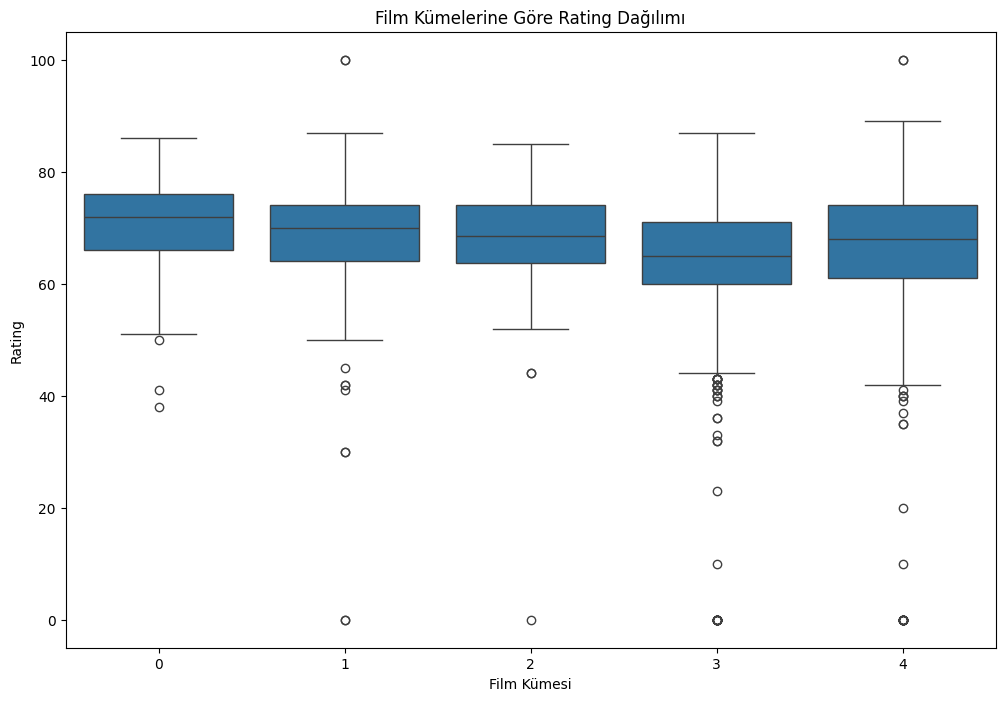

######################################


,genres_Aile,genres_Aksiyon,genres_Animasyon,genres_Belgesel,genres_Bilim-Kurgu,genres_Dram,genres_Fantastik,genres_Gerilim,genres_Gizem,genres_Komedi,genres_Korku,genres_Macera,genres_Müzik,genres_Romantik,genres_Savaş,genres_Suç,genres_TV film,genres_Tarih,genres_Vahşi Batı
1,68.890,28.010,78.180,0.000,18.400,13.360,44.950,0.650,4.400,46.580,2.120,47.880,2.770,8.140,0.000,1.140,4.230,0.330,0.330
3,2.940,25.820,0.220,0.930,11.240,43.340,6.970,34.830,11.020,31.780,19.030,9.910,2.510,17.590,0.000,19.280,0.860,4.270,2.550
2,14.180,72.760,10.070,0.000,45.150,14.550,28.730,16.420,3.360,16.040,2.240,79.480,0.750,2.990,0.000,5.220,0.000,0.370,0.750
4,1.880,28.380,0.850,1.370,8.890,56.580,7.690,28.210,8.550,22.050,15.210,12.820,0.510,21.540,0.000,16.240,0.170,4.790,1.540
0,0.000,44.300,2.010,0.000,3.360,75.840,3.360,16.110,0.670,8.720,2.680,16.780,0.670,13.420,100.000,0.670,0.000,34.900,0.670


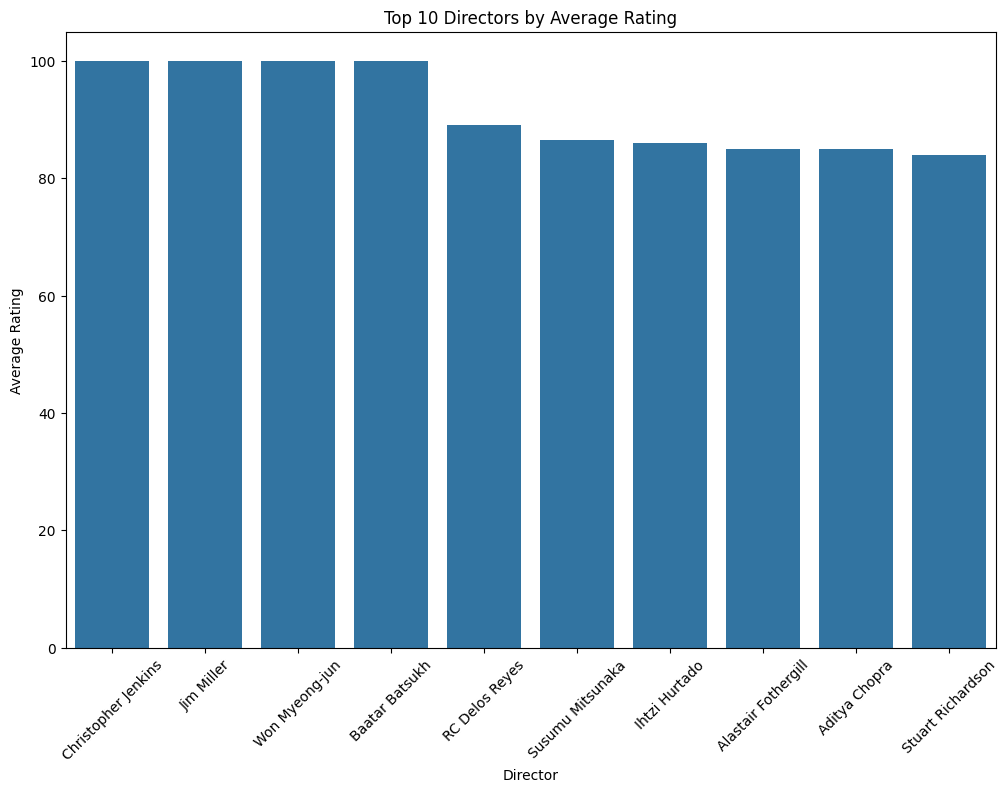

######################################
Root Mean Squared Error: 8.831168351696007
Mean Squared Error: 77.98953445599717


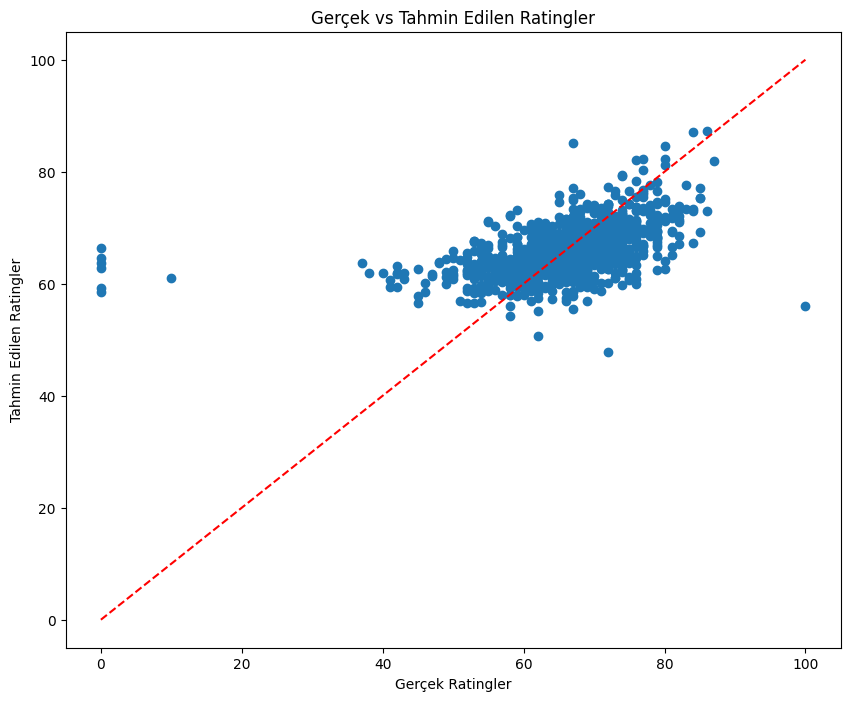

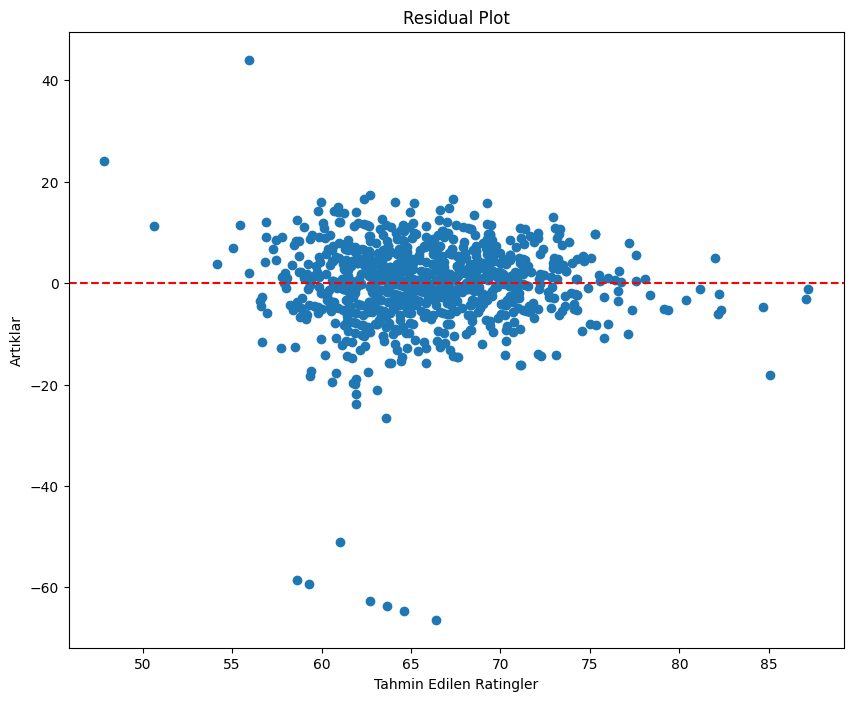

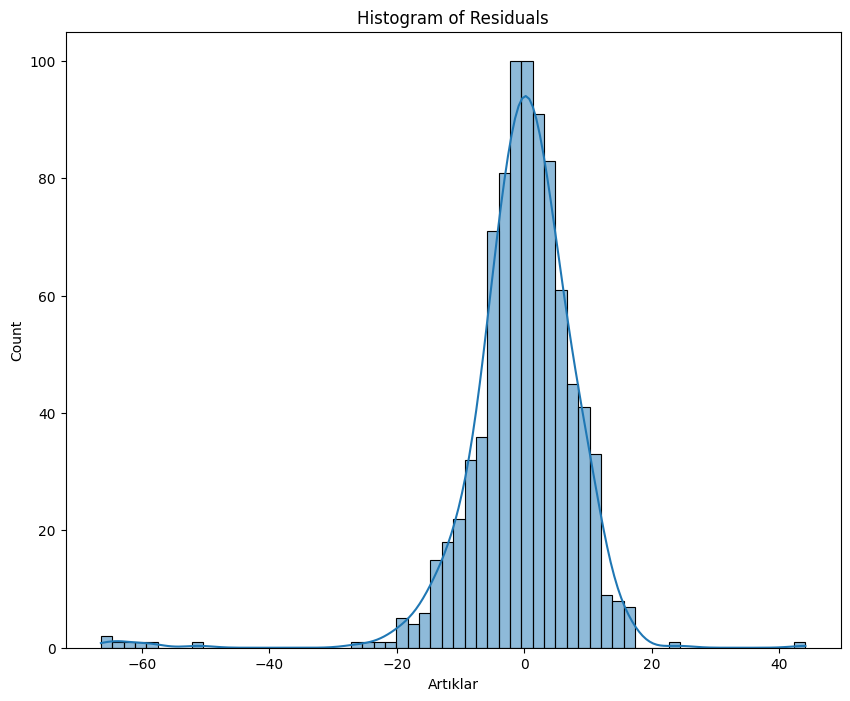

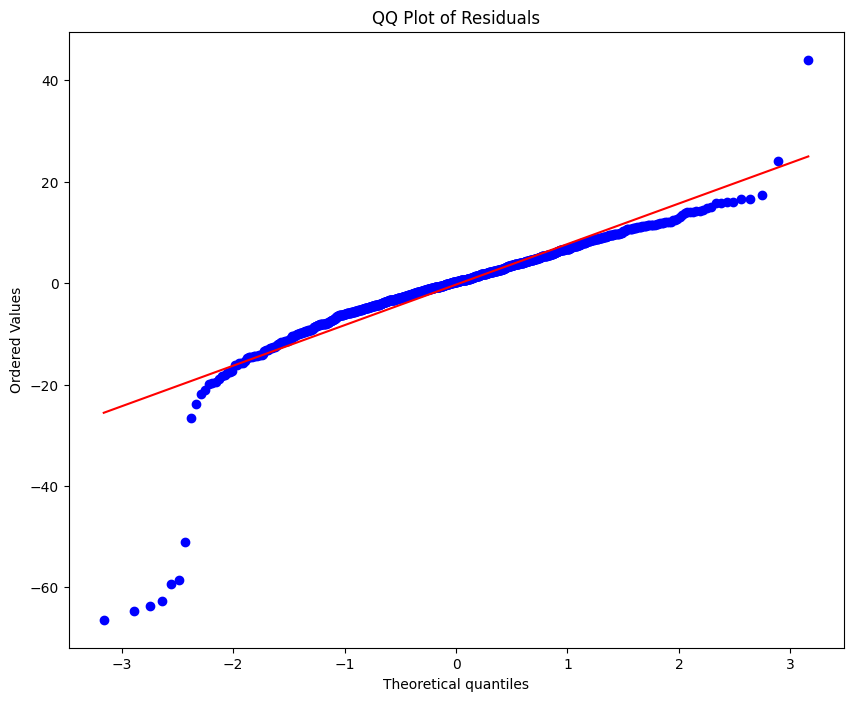

In [ ]:
df = load()
df, X_scaled, scaler = preprocess_data(df)

# Filmleri kümeler halinde gruplandırdık.
movie_clusters = cluster_movies(X_scaled)

# Yönetmenleri kümeler halinde gruplandırdık.
director_clusters = cluster_directors(df)

#Visualization
visualize_clusters(df, movie_clusters)
visualize_boxplot(df)
genre_ratios_df = visualize_boxplot(df)
visualize_top_directors(df)

# Model
model, X_test, y_test, y_pred = train_model(df)

features = ['rating', 'release_year', 'runtime', 'budget', 'revenue', 'net_gain'] + \
           [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('release_season_')]

evaluate_model_performance(y_test, y_pred)

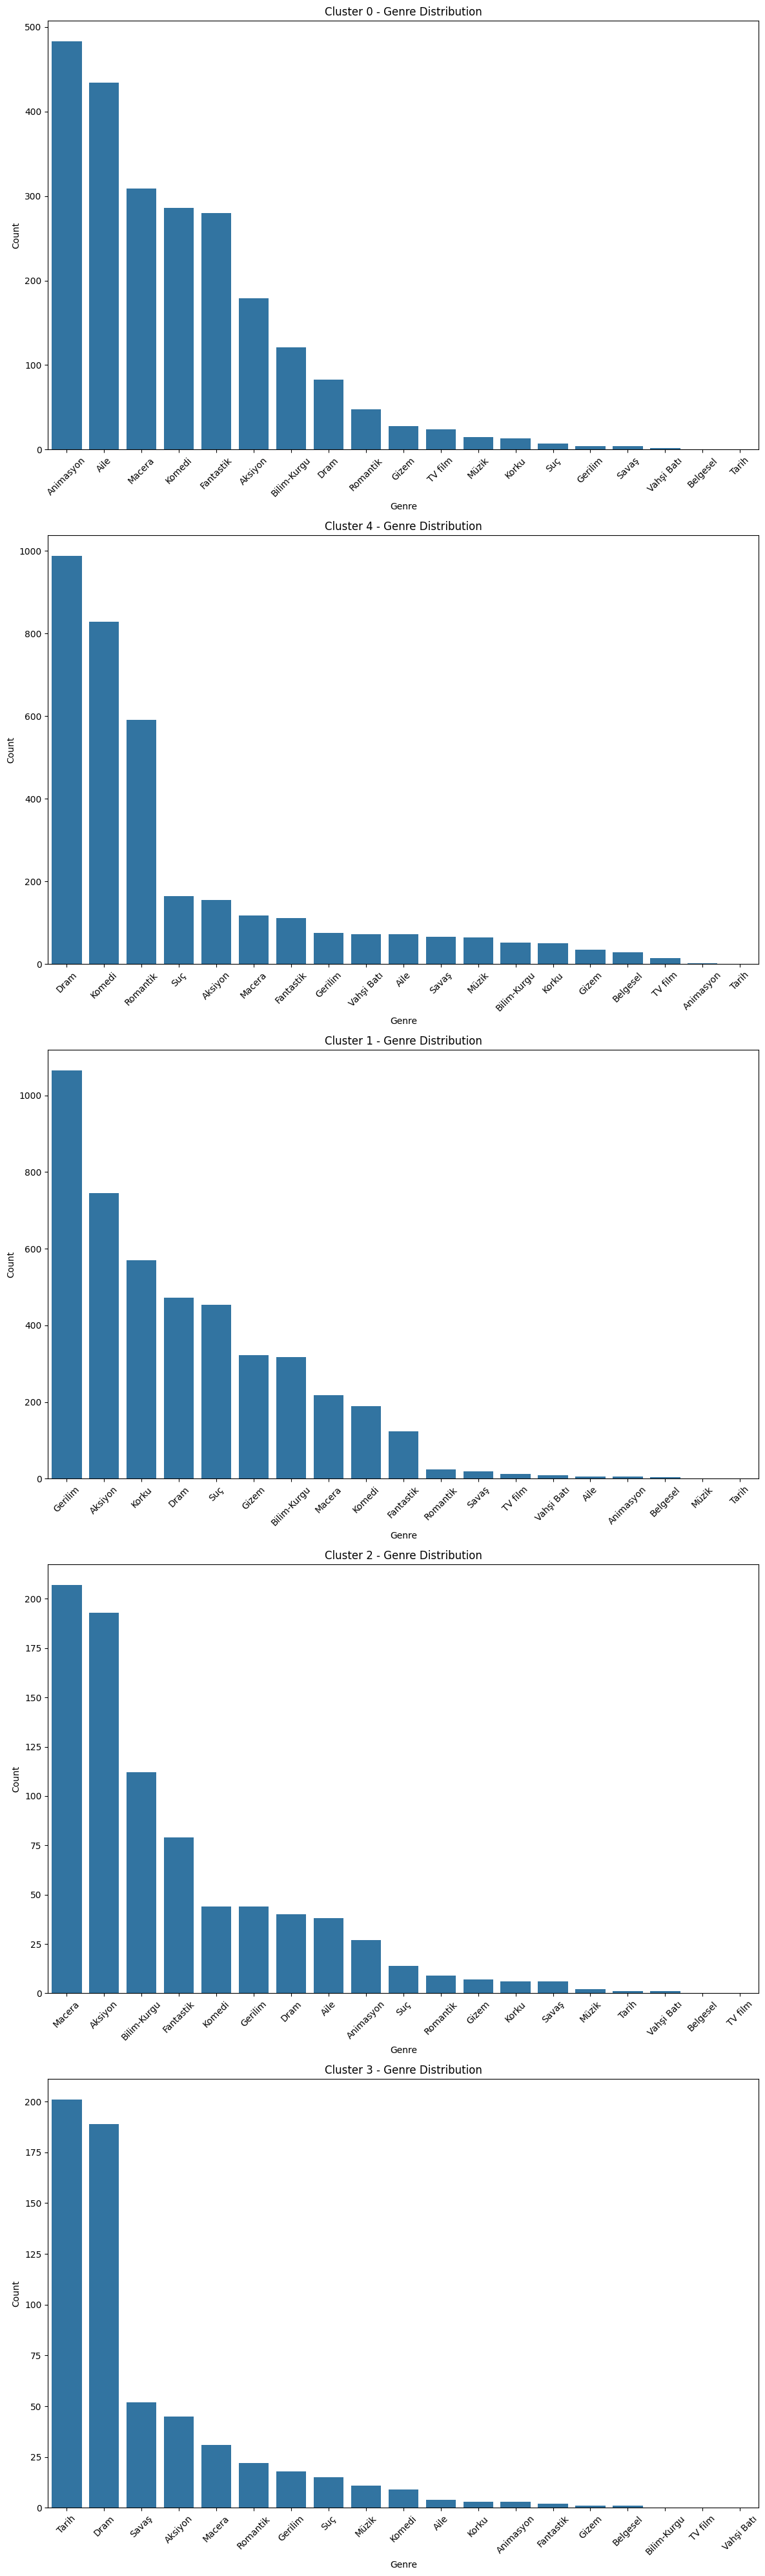

In [ ]:
visualize_genres_in_clusters(df)

Belirtilen feature lara göre yeni çıkacajk bir filmin ratingini tahmin edebiliriz.

In [ ]:
#featurelar için default değerler belirledik.

default_values = {
    'release_year': df['release_year'].mean(),
    'runtime': df['runtime'].mean(),
    'budget': df['budget'].mean(),
    'revenue': df['revenue'].mean(),
    'net_gain': df['net_gain'].mean(),
    'film_count': df['film_count'].mean(),
    'avg_rating': df['avg_rating'].mean(),
}

# Language ve Genres sütunları için en yaygın değerleri belirledik.
language_cols = [col for col in df.columns if col.startswith('language_')]
genre_cols = [col for col in df.columns if col.startswith('genres_')]
season_cols = [col for col in df.columns if col.startswith('season_')]

# Language, Genres ve Season sütunları için default değerler 0 olarak belirlenir
default_values.update({col: 0 for col in language_cols + genre_cols + season_cols})

# Örnek: En yaygın dil ve türü default olarak 1 yapma
default_values['language_İngilizce'] = 1
default_values['genres_Dram'] = 1
default_values['season_Summer'] = 1

In [ ]:
def predict_new_movie(model, scaler, features_dict):
    """
    Yeni bir film için rating tahmini yapar.

    Parametreler:
    model: Eğitilmiş regresyon modeli
    scaler: Eğitim verileri üzerinde kullanılan scaler
    features_dict: Yeni film için özellikleri sözlük olarak vereceğiz.

    Dönüş:
    Tahmin edilen rating
    """

    # Gerekli özelliklerin listesi
    features_list = ['release_year', 'runtime', 'budget', 'revenue', 'net_gain', 'film_count', 'avg_rating'] + \
                    [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('season_')]

    # featurelar için default değerler (genel ortalamalar veya en yaygın değerler)
    new_movie = default_values.copy()

    # Yeni filmin özelliklerini güncelle ve df'e çevir.
    new_movie.update(features_dict)
    new_movie_df = pd.DataFrame(new_movie, index=[0])

    # normalization
    new_movie_scaled = scaler.transform(new_movie_df)

    # prediction
    predicted_rating = model.predict(new_movie_scaled)

    return predicted_rating[0]

In [ ]:
# Örnek kullanımı
new_movie_features = {
    'release_year': 2024,
    'runtime': 120,
    'budget': 150000000,
    'film_count': 10,
    'avg_rating': 70,
    'language_İngilizce': 1,
    'genres_Aksiyon': 1,
    'genres_Macera': 1,
    'season_Summer': 1
}

predicted_rating = predict_new_movie(model, scaler, new_movie_features)
print(f"Tahmin Edilen Rating: {predicted_rating}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- rating


In [ ]:
df.head(20)

,title,rating,director,writer,runtime,budget,revenue,language_Almanca,language_Fransızca,language_Japonca,language_Korece,language_Other,language_Rusça,language_Çince,language_İngilizce,language_İtalyanca,Aile,Aksiyon,Animasyon,Belgesel,Bilim-Kurgu,Dram,Fantastik,Gerilim,Gizem,Komedi,Korku,Macera,Müzik,Romantik,Savaş,Suç,TV film,Tarih,Vahşi Batı,release_year,season_Autumn,season_Spring,season_Summer,season_Winter,net_gain,film_count,avg_rating,movie_cluster
0,Garfield,64,Mark Dindal,NaN,101,125000000.000,22000000.000,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2024,False,True,False,False,0.000,3,66.333,2
1,Hayalet Avcıları: Ürperti,66,Gil Kenan,Gil Kenan,115,100000000.000,195102874.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,2024,False,True,False,False,95102874.000,3,60.333,2
2,Arınma,62,Michael Mohan,NaN,89,9000000.000,22314913.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,2024,False,True,False,False,13314913.000,2,64.000,2
4,Çıkış Yok,64,Claudio Fäh,Andy Mayson,95,41278591.222,122113877.309,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2024,False,False,False,True,0.000,2,64.000,3
5,Ape vs. Mecha Ape,53,Marc Gottlieb,Marc Gottlieb,80,41278591.222,122113877.309,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,False,True,False,False,0.000,1,53.000,2
6,Kung Fu Panda 4,71,Mike Mitchell,Jonathan Aibel,94,85000000.000,520540090.000,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2024,False,True,False,False,435540090.000,6,65.167,4
7,Dune: Çöl Gezegeni Bölüm İki,82,Denis Villeneuve,NaN,165,190000000.000,704300257.000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2024,False,True,False,False,514300257.000,3,80.333,4
8,Maymunlar Cehennemi: Yeni Krallık,69,Wes Ball,Josh Friedman,145,52333333.333,316263750.667,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2024,False,True,False,False,0.000,4,69.750,2
10,Sen İhtimali,76,Michael Showalter,NaN,116,41278591.222,122113877.309,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2024,False,True,False,False,0.000,2,74.500,2
11,Godzilla Minus One,77,Takashi Yamazaki,NaN,125,15000000.000,115857413.000,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2023,True,False,False,False,100857413.000,3,75.667,0
